In [12]:
import os
import argparse
import builtins
import time
import numpy as np

import torch
import torch.nn.functional as F
from torch import multiprocessing as mp
import torch.distributed as dist

import utils
from model import AVENet
from DatasetLoader import GetAudioVideoDataset
from train import train, validate
# from datasets import get_train_dataset, get_test_dataset


import argparse

In [9]:
class Args:
    def __init__(self):
        # Model and experiment configurations
        self.model_dir = './checkpoints'  # Directory to save model checkpoints
        self.experiment_name = 'hdvsl_vggss'  # Experiment name for checkpointing and logging

        # Dataset paths and configurations
        self.trainset = 'vggss'  # Name of the training dataset (e.g., flickr, vggss)
        self.testset = 'vggss'  # Name of the test dataset (e.g., flickr, vggss)
        self.image_size = 224  # Height and width of inputs

        # Model hyperparameters as used in AVENet class
        self.epsilon = 0.65  # Threshold for positive cases in similarity calculation
        self.epsilon2 = 0.4  # Threshold for negative cases in similarity calculation
        self.tri_map = True  # Use tri-map for additional negative cases
        self.Neg = True  # Include negative samples in similarity calculation
        self.random_threshold = 0.03  # Threshold for random sampling (if used)

        # Training parameters
        self.epochs = 20  # Total number of training epochs
        self.batch_size = 128  # Batch size for training
        self.init_lr = 0.0001  # Initial learning rate
        self.seed = 12345  # Random seed for reproducibility

        # Distributed training parameters
        self.workers = 8  # Number of workers for data loading
        self.gpu = None  # GPU id to use
        self.world_size = 1  # Total number of nodes for distributed training
        self.rank = 0  # Node rank for distributed training
        self.node = 'localhost'  # Node hostname
        self.port = 12345  # Port for distributed training communication
        self.dist_url = 'tcp://localhost:12345'  # URL for distributed training
        self.multiprocessing_distributed = False  # Use multi-processing distributed training

args = Args()

In [ ]:
# 모델 초기화
model = AVENet(args)
model.cuda()  # GPU 설정
optimizer, scheduler = utils.build_optimizer_and_scheduler_adam(model, args)  # 옵티마이저 설정

# 데이터 로더 설정
train_dataset = GetAudioVideoDataset(args, mode='train')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False, num_workers=16)
test_dataset = GetAudioVideoDataset(args, mode='test')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=16)

# 학습 및 검증 루프 실행
for epoch in range(args.epochs):
    train(train_loader, model, optimizer, epoch, args)
    validate(test_loader, model, args)

ValueError: too many values to unpack (expected 4)

: 

# pth 보기

In [ ]:
# pth 저장된 파일 확인하기


# Image 탐색

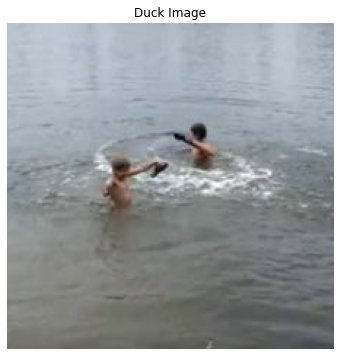

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def show_image(image_path, title="Image"):
    """
    Display an image given its file path.
    
    Args:
        image_path (str): Path to the image file.
        title (str): Title for the displayed image.
    """
    try:
        # 이미지 읽기
        img = mpimg.imread(image_path)
        
        # 이미지 시각화
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')  # 축 제거
        plt.title(title)
        plt.show()
    except FileNotFoundError:
        print(f"Error: The file at {image_path} was not found.")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
image_path = "/mnt/scratch/users/individuals/VGGsound_individual/train/sample_frames/frame_4"
show_image(os.path.join(image_path, 'o1tj9l9Sfho_000068.jpg') , title="Duck Image")

# Audio 탐색

In [38]:
from IPython.display import Audio

def play_audio(wav_path):
    """
    주어진 wav 파일 경로를 받아 오디오를 재생합니다.

    Args:
        wav_path (str): 재생할 .wav 파일 경로
    Returns:
        Audio: Jupyter Notebook에서 오디오를 재생할 객체
    """
    try:
        print(f"Playing audio: {wav_path}")
        return Audio(wav_path, autoplay=True)
    except FileNotFoundError:
        print(f"Error: The file at {wav_path} was not found.")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
play_audio(os.path.join('/mnt/scratch/users/individuals/VGGsound_individual/test/sample_audio', 'sc7KNFUEdfY_000030.wav'))  # .wav 파일 경로 입력


Playing audio: /mnt/scratch/users/individuals/VGGsound_individual/test/sample_audio/sc7KNFUEdfY_000030.wav


# Retrieval task 수행

In [11]:
from DatasetLoader import GetAudioVideoDataset
import argparse

args = argparse.Namespace(
    image_size=224,
    multiprocessing_distributed=False,
    epsilon=0.65,
    epsilon2=0.4,
    tri_map=True,
    Neg=True,
    random_threshold=0.03
)

dataset = GetAudioVideoDataset(args) # test dataset 생성

rqS5w4qQ3i8_000042


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # GPU 1 사용

import torch
print(f"Using GPU: {torch.cuda.current_device()}")  # 현재 선택된 GPU 출력

Using GPU: 0


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from DatasetLoader import GetAudioVideoDataset
from model import AVENet
import json
import os


def load_labels(split, ids):
    # 테스트 데이터셋 라벨 로드 (사용자 정의 함수)
    # 'split'과 'ids'를 사용하여 적절히 라벨 로드
    pass

def combine_features(image_emb, audio_emb, alpha=0.5):
    combined_emb = alpha * image_emb + (1 - alpha) * audio_emb
    return F.normalize(combined_emb, dim=-1)


def extract_video_ids(json_paths):
    video_ids = []

    for json_path in json_paths:
        with open(json_path, 'r') as f:
            data = json.load(f)
            # 'video_id'만 추출하여 리스트에 추가
            video_ids.extend([item["video_id"] for item in data["data"]])

    return video_ids


def retrieve_and_visualize(image_id, audio_id, model_path, args, alpha=0.5):
    # 모델 초기화 및 가중치 로드
    model = AVENet(args)
    model.cuda()
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(model_path, map_location=device)

    model.load_state_dict(checkpoint['model'])
    print(f"Model loaded from {model_path}")


    # 유사도 계산을 위한 평가 도구 초기화
    image_embeddings = []
    audio_embeddings = []
    ids = []

    # JSON 파일 경로
    train_json_path = '/mnt/scratch/users/individuals/VGGsound_individual/metadata/train_a_third.json'
    test_json_path = '/mnt/scratch/users/individuals/VGGsound_individual/metadata/test.json'

    total_dataset = GetAudioVideoDataset(args) # test dataset 생성
    total_loader = torch.utils.data.DataLoader(total_dataset, batch_size=16, shuffle=False, num_workers=16)

    # 데이터셋에서 이미지와 오디오 임베딩 추출
    for step, (image, spec, _, name, _) in tqdm(enumerate(total_loader), desc="Embedding Extraction", total=len(total_loader)):
        image, spec = image.cuda().float(), spec.cuda().float()

        with torch.no_grad():
            img_emb, aud_emb = model.extract_features(image, spec) # (B, 512)
            
            # 이미지와 오디오 임베딩이 4차원일 경우 평균 풀링 적용
            if img_emb.dim() == 4:
                img_emb = F.avg_pool2d(img_emb, kernel_size=(img_emb.size(2), img_emb.size(3))).squeeze()
            if aud_emb.dim() == 4:
                aud_emb = F.avg_pool2d(aud_emb, kernel_size=(aud_emb.size(2), aud_emb.size(3))).squeeze()

        # 추출된 이미지와 오디오 임베딩 추가
        image_embeddings.append(img_emb)
        # audio_embeddings.append(aud_emb)
        ids.extend(name)

    # 텐서로 결합
    image_embeddings = torch.cat(image_embeddings, dim=0) # (N, 512)
    # audio_embeddings = torch.cat(audio_embeddings, dim=0)    

    # target video_id, audio_id 추출
    video_ids = extract_video_ids([train_json_path, test_json_path])
    image_idx = video_ids.index(image_id)
    audio_idx = video_ids.index(audio_id)
    image_data = total_dataset[image_idx][0] # (3, 224, 224)
    audio_data = total_dataset[audio_idx][1] # (1, 257, 671)
    
    input_image_emb, input_audio_emb = model.extract_features(image_data.unsqueeze(0), audio_data.unsqueeze(0)) # (1, 512)

    # 입력 이미지와 오디오 임베딩을 조합
    combined_emb = combine_features(input_image_emb, input_audio_emb, alpha=alpha) # (1, 1, 512)

    print("Combined embedding shape:", combined_emb.size())
    # 유사도 계산
    similarity_scores = torch.mm(combined_emb, image_embeddings.T)  # 조합된 임베딩과 데이터셋 이미지 임베딩 간 유사도 계산
    _, topk_indices = similarity_scores.topk(10, largest=True, sorted=True)

    # 검색 결과 시각화
    fig, axes = plt.subplots(1, 11, figsize=(25, 5))

    # 입력 이미지
    input_img = plt.imread(os.path.join('/mnt/scratch/users/individuals/VGGsound_individual/train/sample_frames/frame_4', f"{image_id}.jpg"))
    axes[0].imshow(input_img)
    axes[0].axis('off')
    axes[0].set_title("Input Image")

    # 검색된 이미지
    for i, idx in enumerate(topk_indices[0]):
        img_id = ids[idx]
        print(f"Rank {i+1}: {img_id}")
        retrieved_img_path = os.path.join('/mnt/scratch/users/individuals/VGGsound_individual/train/sample_frames/frame_4', f"{img_id}.jpg")
        retrieved_img = plt.imread(retrieved_img_path)  # 경로에서 이미지 읽기
        axes[i + 1].imshow(retrieved_img)
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f"Rank {i+1}")

    plt.show()

    return [ids[idx] for idx in topk_indices[0].cpu().numpy()]  # 검색된 이미지 경로 반환


load pretrained res-18
Model loaded from /mnt/scratch/users/sally/checkpoints/best.pth


Embedding Extraction: 100%|██████████| 4787/4787 [07:08<00:00, 11.16it/s]


Combined embedding shape: torch.Size([1, 512])


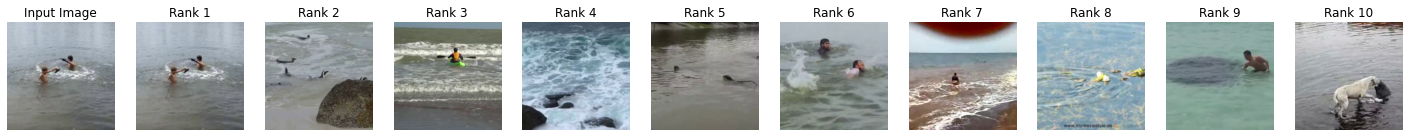

In [4]:
import argparse

args = argparse.Namespace(
    image_size=224,
    multiprocessing_distributed=False,
    epsilon=0.65,
    epsilon2=0.4,
    tri_map=True,
    Neg=True,
    random_threshold=0.03
)

testdataset = GetAudioVideoDataset(args) # test dataset 생성
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=128, shuffle=False, num_workers = 1)

retrieved_images = retrieve_and_visualize(
    image_id='yBBlpK1Z9iQ_000007',  # 물 사진  
    audio_id="dDgGMInTqTo_000052",  # 오리 소리    
    model_path="/mnt/scratch/users/sally/checkpoints/best.pth",                   # 학습된 모델 가중치
    args = args,
    alpha=0.5                                # 이미지와 오디오 조합 비율
)

In [ ]:
import argparse

args = argparse.Namespace(
    image_size=224,
    multiprocessing_distributed=False,
    epsilon=0.65,
    epsilon2=0.4,
    tri_map=True,
    Neg=True,
    random_threshold=0.5
)


retrieved_images = retrieve_and_visualize(
    image_id='-1Vd89MCLJU_000647',  # 눈 사진  
    audio_id="Iwx2gM8sN_M_000426",  # 기차 소리
    image_embeddings=image_embeddings_AI,  #
    model_path="/mnt/scratch/users/sally/checkpoints/best_AI.pth",                   # 학습된 모델 가중치
    args = args,
    alpha=0.55                              # 이미지와 오디오 조합 비율
)

In [ ]:

retrieved_images = retrieve_and_visualize(
    image_id='XCwUoV7iRF4_000289',  # 나무 사진  
    audio_id="xT3FdVVJj8Y_000051",  # 휘파람 소리
    image_embeddings=image_embeddings_AI,  #
    model_path="/mnt/scratch/users/sally/checkpoints/best_AI.pth",                   # 학습된 모델 가중치
    args = args,
    alpha=0.56                              # 이미지와 오디오 조합 비율
)

In [ ]:
import argparse

args = argparse.Namespace(
    image_size=224,
    multiprocessing_distributed=False,
    epsilon=0.65,
    epsilon2=0.4,
    tri_map=True,
    Neg=True,
    random_threshold=0.5
)



retrieved_images = retrieve_and_visualize(
    image_id='k9s1j5OiXNw_000055',  # 사이렌 사진  
    audio_id="A0ciL4tAh9c_000020",  # 개 소리
    image_embeddings=image_embeddings_AI,  #
    model_path="/mnt/scratch/users/sally/checkpoints/best_AI.pth",                   # 학습된 모델 가중치
    args = args,
    alpha= 0.5                       # 이미지와 오디오 조합 비율
)